# Glacier dynamics toy model

Toy model based on the Shallow Ice Approximation (SIA), mixing
partial differential equations (PDEs), neural networks and model
interpretation using SINDy.

The equation we are going to use is the Shallow Ice approximation:

$$ \frac{\partial H}{\partial t} = \dot b + \nabla \cdot \left( \left( u_b + \frac{2A}{n+2} H \right) H^{n+1} (\rho g)^n  \, || \nabla S ||^{n-1} \nabla S \right) $$

with 
- $H$ the glacier ice thickness
- $n$ the exponent in Glen's Law
- $A$ the deformation sliding factor in Glen's Law
- $u_b$ is the basal slip velocity 
- $\dot b$ the point mass balance 
- $S$ the surface elevation of the glacier

Assuming that the basal slip velocity is zero and ignoring the mass balance term, the SIA equation is equivalent to the 2D diffusivity equation 

$$ \frac{\partial H}{\partial t} = \nabla \cdot \left( D \, \nabla (B + H) \right) $$

where $B$ is the coordinate of the bed (fixed) and $D$ is a nonlinear diffusivity coefficient given by: 

$$ D (H, \nabla S) = \frac{2A}{n+2}(\rho g)^n H^{n+2} || \nabla S ||^{n-1} $$

### Questions

1) For the real data example, the first steps of the numerical simulation are basically doing some kind of smoothing od the surface elevations. Is there another way of doing this?

In [2]:
## Environment and packages
cd(@__DIR__)
using Pkg; Pkg.activate("."); Pkg.instantiate()
using Infiltrator
#using Debugger

# using Flux, DiffEqFlux, DataDrivenDiffEq
# using Flux: @epochs
# using Zygote
#using DifferentialEquations
#using ComponentArrays
using PaddedViews
using Interpolations
#using Parameters: @unpack
using Plots; gr()
using Base: @kwdef
using Statistics
#using ModelingToolkit
using LinearAlgebra
using GeoArrays
using CUDA
using HDF5
using JLD, Printf

const USE_GPU = false # switch here to use GPU
using ParallelStencil
using ParallelStencil.FiniteDifferences2D
@static if USE_GPU
    @init_parallel_stencil(CUDA, Float64, 2)
else
    @init_parallel_stencil(Threads, Float64, 2)
end



  Activating environment at `~/Desktop/Jordi/Julia/odinn_toy_model/Project.toml`


### Global parameters

Which A value should be used? 

In [3]:
# Global parameters
A = 2e-16
# A = 1.3e-24 #2e-16  1 / Pa^3 s
# A *= 60 * 60 * 24 * 365.25 # 1 / Pa^3 yr

ρ = 900 # kg / m^3
g = 9.81 # m / s^2
n = 3

Γ = 2 * A * (ρ * g)^n / (n+2) # 1 / m^3 s

# Parameter that control the stepsize of the numerical method 
# η < 1 is requiered for stability
η = 0.2;

# handle output
do_plot = true
do_save = true

true

### Types
Types to manage glacier raster data and machine learning hyperparameters

In [4]:
# what is the difference between using @kwdef and using the default constructor?

@kwdef mutable struct Hyperparameters
    batchsize::Int = 500     # batch size
    η::Float64 = 0.1         # learning rate
    epochs::Int = 500        # number of epochs
    use_cuda::Bool = true    # use gpu (if cuda available)
end

mutable struct Glacier
    bed::Array{Float32}    # bedrock height
    thick::Array{Float32}  # ice thickness
    vel::Array{Float32}    # surface velocities
    MB::Array{Float32}     # surface mass balance
end

### Functions 
Some functions to deal with staggered grids with efficient parallelization

In [5]:
#########################################################################
####  Parallelized functions supported by ParallelStencil.jl macros  ####
#########################################################################

# Staggered grid functions
# CPU functions: finite difference stencil operation support functions
@views av(A)  = 0.25*(A[1:end-1,1:end-1].+A[2:end,1:end-1].+A[1:end-1,2:end].+A[2:end,2:end])
@views inn(A) = A[2:end-1,2:end-1]

# GPU function
@parallel_indices (iy) function bc_x!(A::Data.Array)
    A[1  , iy] = A[2    , iy]
    A[end, iy] = A[end-1, iy]
    return
end

@parallel_indices (ix) function bc_y!(A::Data.Array)
    A[ix, 1  ] = A[ix, 2    ]
    A[ix, end] = A[ix, end-1]
    return
end

@parallel function assign!(Aold, A)
    @all(Aold) = @all(A)
    return
end

@parallel function compute_∇S!(S, dSdx, dSdy, Δx, Δy)
    # Compute surface gradients on edges
    @all(dSdx) = @d_xa(S) / dx
    @all(dSdy) = @d_ya(S) / dy 
    @all(∇S) = sqrt.(@av_ya(dSdx).^2 .+ @av_xa(dSdy).^2)
    return
end

@parallel function compute_diffusivity!(D, H, ∇S, Γ, n)
    # Compute diffusivity on secondary nodes
    @all(D) = Γ * @av(H)^(n + 2) * @all(∇S).^(n - 1)
    return
end

@parallel function compute_flux!(Fx, Fy, D, S, dt, dx, dy)
    # Compute flux components with dS on edges
    @all(Fx)  = -@av_ya(D)*@d_xi(S)/dx
    @all(Fy)  = -@av_xa(D)*@d_yi(S)/dy
    #  Flux divergence
    @all(F) = -(@d_xa(Fx) / dx + @d_ya(Fy) / dy) 
    return
end

@parallel function compute_dHdt!(dτ, ResH, dHdt, D, H, Hold, F, MB, dτ_scaling, cfl, ϵ, dt, damp, dx, dy)
    @all(dτ) = dτ_scaling*min(10.0, 1.0/(1.0/dt + 1.0/(cfl/(ϵ + @av(D)))))
    @all(ResH) = -(@inn(H) - @inn(Hold))/dt + @all(F) + @inn(MB)  # ice flux + MB
    @all(dHdt) = @all(dHdt)*damp + @all(ResH)
    return
end

@parallel function compute_H!(H, dHdt, dτ)
    @inn(H) = max(0.0, @inn(H) + @all(dτ)*@all(dHdt) )
    return
end

@parallel function compute_velocities!(Vx, Vy, D, H, dSdx, dSdy, ϵ)
    @all(Vx) = -@all(D)/(@av(H) + ϵ)*@av_ya(dSdx)
    @all(Vy) = -@all(D)/(@av(H) + ϵ)*@av_xa(dSdy)
    return
end

##################################

"""
    as_geoarray(A, template::AbstractGeoArray)

Make a GeoArray with the data from `A` and the geo-info from `template`.

Kwargs:
- name: give it a name
- staggered: uses a staggered grid, i.e. of size (nx-1,ny-1)
"""
function as_geoarray(A, template::AbstractGeoArray; name=nothing, staggerd=false)
    @assert length(size(A))==2
    dd = if staggerd
        x, y = dims(template)
        (X( 0.5*(val(x)[2:end] + val(x)[1:end-1]), mode=x.mode, metadata=x.metadata),
         Y( 0.5*(val(y)[2:end] + val(y)[1:end-1]), mode=y.mode, metadata=y.metadata))
    else
        dims(template)
    end
    return GeoArray(A, dims=dd, name=name)
end

# Converts empty grid cells to NaNs
function void2nan!(x, void)
    for i in eachindex(x)
        @inbounds x[i] = ifelse(x[i]==void, NaN, x[i])
    end
end

# Smooth glacier surface
@views function smooth!(A)
    A[2:end-1,2:end-1] .= A[2:end-1,2:end-1] .+ 1.0./4.1.*(diff(diff(A[:,2:end-1], dims=1), dims=1) .+ diff(diff(A[2:end-1,:], dims=2), dims=2))
    A[1,:]=A[2,:]; A[end,:]=A[end-1,:]; A[:,1]=A[:,2]; A[:,end]=A[:,end-1]
    return
end

LoadError: UndefVarError: AbstractGeoArray not defined

### Load the data
We use simulations from Harry's SIA model as a ground truth dataset to perform some tests.

- Lat/Lon coordinates will later on be available (from the `Glacier directory` in OGGM). 

In [ ]:
# Load the HDF5 file with Harry's simulated data
root_dir = pwd()
argentiere_f = h5open(joinpath(root_dir, "data/Argentiere_2003-2100_aflow2e-16_50mres_rcp2.6.h5"), "r")

🗂️ HDF5.File: (read-only) /Users/Bolib001/Desktop/Jordi/Julia/odinn_toy_model/data/Argentiere_2003-2100_aflow2e-16_50mres_rcp2.6.h5
├─ 🔢 bed
├─ 🔢 s_apply_hist
├─ 🔢 thick_hist
└─ 🔢 vel_hist

In [ ]:
# Fill the Glacier structure with the retrieved data
argentiere = Glacier(HDF5.read(argentiere_f["bed"])[begin:end-2,:],
                     HDF5.read(argentiere_f["thick_hist"])[begin:end-2,:,2:end],
                     HDF5.read(argentiere_f["vel_hist"])[begin:end-2,:,2:end],
                     HDF5.read(argentiere_f["s_apply_hist"])[begin:end-2,:,2:end])

# Update mass balance data with NaNs
void2nan!(argentiere.MB, argentiere.MB[1,1,1])
# Interpolate mass balance to daily values
MB_weekly = interpolate(argentiere.MB/54, (NoInterp(), NoInterp(), BSpline(Linear())))

# Domain size
nx = size(argentiere.bed)[1]
ny = size(argentiere.bed)[2];

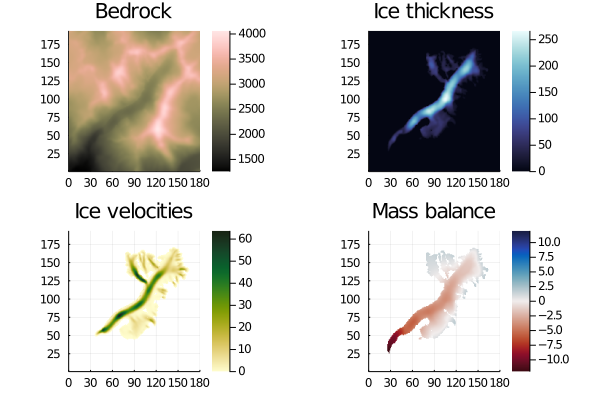

In [ ]:
# Argentière bedrock
hm01 = heatmap(argentiere.bed, c = :turku, title="Bedrock")
# Argentière ice thickness for an individual year
hm02 = heatmap(argentiere.thick[:,:,1], c = :ice, title="Ice thickness")
# Surface velocities
hm03 = heatmap(argentiere.vel[:,:,15], c =:speed, title="Ice velocities")
hm04 = heatmap(argentiere.MB[:,:,90], c = cgrad(:balance,rev=true), clim=(-12,12), title="Mass balance")
hm0 = plot(hm01,hm02,hm03,hm04, layout=4, aspect_ratio=:equal, xlims=(0,180))
display(hm0)

There are two examples we can run:

   - Using the real data for the Argèntiere glacier
   - Using simulated data for which we have the exact solution of the SIA equation in order to test our numerical method.

In [ ]:
example = "Argentiere"
#example = "Gaussian" # Fake

if example == "Argentiere"
    
    B  = Data.Array(argentiere.bed)
    H₀ = Data.Array(argentiere.thick[:,:,1])
 
    # Spatial and temporal differentials
    dx = dy = 50 #m (Δx = Δy)
    
elseif example == "Gaussian"
    
    B = zeros(Float64, (nx, ny))
    σ = 1000
    H₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / σ ) for i in 1:nx, j in 1:ny ]    
    
    # Spatial and temporal differentials
    dx = dy = 50 #m (Δx = Δy)
    
end

50

In [ ]:
##########################################
#####  Forward model initialization  #####
##########################################

H = copy(H₀)
# Time 
t = 0
t₁ = 10

itMax    = 1e5             # number of iteration (max)
nout     = 200             # error check frequency
tolnl    = 1e-6            # nonlinear tolerance
ϵ        = 1e-4            # small number
damp     = 0.85            # convergence accelerator (this is a tuning parameter, dependent on e.g. grid resolution)
dτ_scaling   = 1.0/3.0     # iterative dτ scaling (this is a tuning parameter, dependent on e.g. grid resolution)
dt      = 1/54             # physical timestep in years

# derived numerics
cfl      = max(dx^2,dy^2)/4.1

# Grid initialization
S       = @zeros(nx  , ny  )
dSdx    = @zeros(nx-1, ny  )
dSdy    = @zeros(nx  , ny-1)
∇S      = @zeros(nx-1, ny-1)
D       = @zeros(nx-1, ny-1)
Fx      = @zeros(nx-1, ny-2)
Fy      = @zeros(nx-2, ny-1)
F       = @zeros(nx-2, ny-2)
dHdt    = @zeros(nx-2, ny-2)
v       = @zeros(nx, ny)
Vx      = @zeros(nx-1, ny-1)
Vy      = @zeros(nx-1, ny-1)
MB      = @zeros(nx, ny);

Hold    = @zeros(nx, ny)
Err     = @zeros(nx, ny)
dτ      = @zeros(nx-2, ny-2)
ResH    = @zeros(nx-2, ny-2)

# setup for plotting
if do_plot
    H_v = copy(H); H_v .= NaN
    Hice_v = copy(H); Hice_v .= NaN
    S_v = copy(H); S_v .= NaN
    M_v = copy(H); M_v .= NaN
    V_v = as_geoarray(Array(H)[1:end-1,1:end-1], B, name=:vel, staggerd=true); V_v .= NaN
    fontsize  = 7
    opts = (aspect_ratio=1, yaxis=font(fontsize, "Courier"), xaxis=font(fontsize, "Courier"),
            ticks=nothing, framestyle=:box, titlefontsize=fontsize, titlefont="Courier", colorbar_title="",
            xlabel="", ylabel="", xlims=(dims(H_v)[1][1],dims(H_v)[1][end]), ylims=(dims(H_v)[2][end],dims(H_v)[2][1]) )
end

LoadError: UndefVarError: as_geoarray not defined

## Solving the Shallow Ice Approximation

We have two different ways to solve the PDE:


### 1. Solving the ice flow dynamics using ParallelStencil.jl

In [ ]:
@parallel assign!(Hold, H₀)

# Forward implicit scheme with damping using ParallelStencil.jl
it = 0
while t < t₁ && it < itMax

    # Update glacier surface altimetry
    S .= B .+ H

    # Compute surface gradients on edges
    @parallel compute_∇S!(S, dSdx, dSdy, dx, dy)
    # Compute diffusivity on secondary nodes
    @parallel compute_diffusivity!(D, H, ∇S, Γ, n)
    # Compute flux divergence    
    @parallel compute_flux!(Fx, Fy, D, S, dt, dx, dy)
    # Update the glacier ice thickness
    @parallel compute_dHdt!(dτ, ResH, dHdt, D, H, Hold, Fx, Fy, MB, dτ_scaling, cfl, ϵ, dt, damp, dx, dy)
    @parallel compute_H!(H, dHdt, dτ)
    # Compute surface velocities
    @parallel compute_velocities!(Vx, Vy, D, H, dSdx, dSdy, ϵ)

    # Plot evolution
    if do_plot
        H_v .= Array(H)
        S_v .= Array(S)
        M_v .= Array(M)
        V_v .= sqrt.(Array(Vx).^2 .+ Array(Vy).^2); V_v[H_v[1:end-1,1:end-1].==0] .= NaN

        p1 = heatmap(S_v; c=:davos, title="Surface elev. [m]", opts...)
        p2 = heatmap(H_v; c=:davos, title="Ice thickness [m]", opts...)
        p3 = heatmap(log10.(V_v); clims=(0.1, 2.0), title="log10(vel) [m/yr]", opts...)
        p4 = heatmap(M_v; c=:devon, title="Mass Bal. rate [m/yr]", opts...)
        p = plot(p1, p2, p3, p4, size=(400,400), dpi=200); frame(anim) #background_color=:transparent, foreground_color=:white
        ## uncomment if you want a pop-up plot pane showing:
        # display(p)
        savefig("../output_evo/iceflow_argentiere_xpu_$(it).png")
    end
    it += 1

    return  as_geoarray(Array(H),  B, name=:thickness),
            as_geoarray(Array(S),  B, name=:surface),
            as_geoarray(Array(MB), B, name=:MB),
            as_geoarray(Array(Vx), B, name=:vel_x, staggerd=true),
            as_geoarray(Array(Vy), B, name=:vel_y, staggerd=true)

end

LoadError: UndefVarError: H_v not defined

In [ ]:
if(method == "manual")
    # Manual explicit forward scheme implementation
    while t < t₁

        # Update glacier surface altimetry
        S = B .+ H

        # All grid variables computed in a staggered grid
        # Compute surface gradients on edges
        dSdx  .= diff(S, dims=1) / Δx
        dSdy  .= diff(S, dims=2) / Δy
        ∇S .= sqrt.(avg_y(dSdx).^2 .+ avg_x(dSdy).^2)

        # Compute diffusivity on secondary nodes
        D .= Γ * avg(H).^(n + 2) .* ∇S.^(n - 1)

        # Compute flux components
        dSdx_edges = diff(S[:,2:end - 1], dims=1) / Δx
        dSdy_edges = diff(S[2:end - 1,:], dims=2) / Δy
        Fx .= .-avg_y(D) .* dSdx_edges
        Fy .= .-avg_x(D) .* dSdy_edges
        #  Flux divergence
        F .= .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) # MB to be added here 
            
        # Compute the maximum diffusivity in order to pick a temporal step that garantees estability 
        D_max = maximum(D)
        Δt = η * ( Δx^2 / (2 * D_max ))
        append!(Δts, Δt)

        #  Update the glacier ice thickness
        dHdt = F .* Δt   
        global H[2:end - 1,2:end - 1] .= max.(0.0, inn(H) .+ dHdt)
        
        t += Δt
        # println("time: ", t)
        
    end 
end

LoadError: UndefVarError: method not defined

### Plot the glacier evolution

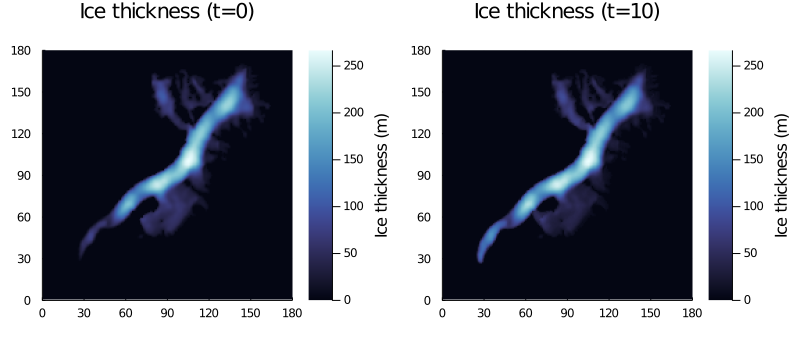

In [ ]:
hm11 = heatmap(H₀, c = :ice, title="Ice thickness (t=0)")
hm12 = heatmap(H, c = :ice, title="Ice thickness (t=$t₁)")
hm1 = plot(hm11,hm12, layout=2, aspect_ratio=:equal, size=(800,350), xlims=(0,180), ylims=(0,180), colorbar_title="Ice thickness (m)", clims=(0,maximum(H₀)), link=:all)

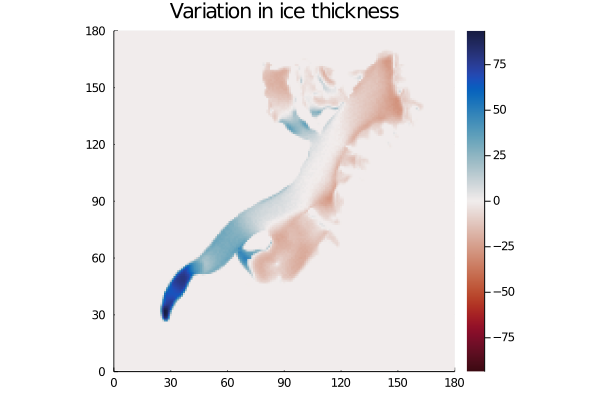

In [ ]:
lim = maximum( abs.(H .- H₀) )
heatmap(H .- H₀, c = cgrad(:balance,rev=true), aspect_ratio=:equal, xlims=(0,180), ylims=(0,180), clim = (-lim, lim), title="Variation in ice thickness")

### Glacier ice velocities

In [ ]:
v = 

heatmap()

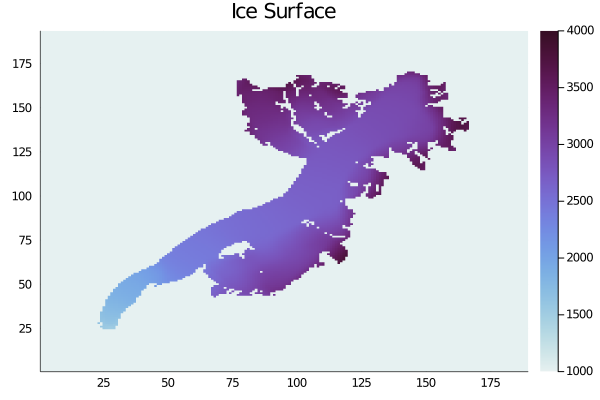

In [ ]:
indicator(x) = if x>0; 1; else; 0; end
S₊ = indicator.(H) .* (B + H);

heatmap(S₊, c = :dense, clim = (1000, 4000), title = "Ice Surface" )

In [ ]:
using Plots; pyplot()
x=1:nx
y=1:ny
f₀(x,y) = H₀[x,y]
f(x,y) = H[x,y]
plot(x,y,f₀,st=:surface,c=cgrad(:algae),camera=(-30,30), fillalpha = 1)
plot!(x,y,f,st=:surface,c=cgrad(:amp),camera=(-30,30), fillalpha = 1)

LoadError: ArgumentError: Package PyPlot not found in current path:
- Run `import Pkg; Pkg.add("PyPlot")` to install the PyPlot package.


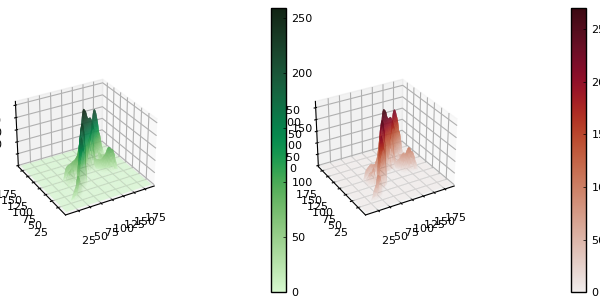

In [ ]:
hm01 = plot(x,y,f₀,st=:surface,c=cgrad(:algae),camera=(-30,30), fillalpha = 1)
hm02 = plot(x,y,f,st=:surface,c=cgrad(:amp),camera=(-30,30), fillalpha = 1)
hm0 = plot(hm01,hm02, layout=(1,2), size=(600,300) )
#display(hm0)

We can plot the $\Delta t$ use in the adaptive method as a function of the iterations:

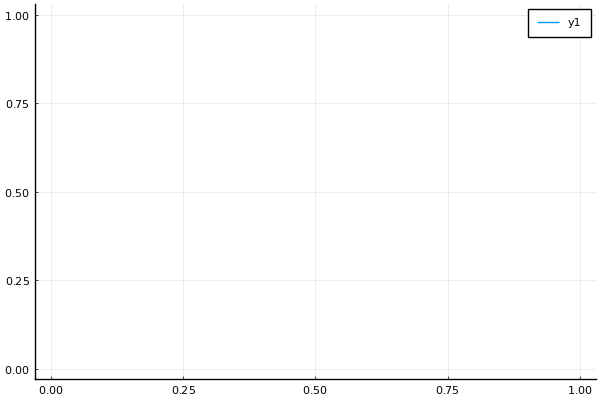

In [ ]:
plot(Δts)